In [3]:
import tensorflow as tf
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df = pd.read_csv('timeseries.csv')

In [5]:
df = df.dropna(subset=['time']) 
df['time'].tail(20)
# df['time'][78886]

96418                                        20201231:1007
96419                                        20201231:1107
96420                                        20201231:1207
96421                                        20201231:1307
96422                                        20201231:1407
96423                                        20201231:1507
96424                                        20201231:1607
96425                                        20201231:1707
96426                                        20201231:1807
96427                                        20201231:1907
96428                                        20201231:2007
96429                                        20201231:2107
96430                                        20201231:2207
96431                                        20201231:2307
96433    G(i): Global irradiance on the inclined plane ...
96434                           H_sun: Sun height (degree)
96435            T2m: 2-m air temperature (degree Celsiu

In [6]:
df = df[:96431:]  # Truncate the DataFrame to include only the first 96,431 rows.

df_multi = df.iloc[:,1:5]  # Select columns from index 1 to 4 (inclusive), typically removing the time column assuming it's at index 0.

df.tail(30)  # Display the last 30 rows of the DataFrame to check the end of the dataset.

print(df_multi.head(10))  # Print the first 10 rows of the subset DataFrame to verify the correct columns and data.

print(df_multi.dtypes)  # Print the data types of the columns in the subset DataFrame to ensure they are appropriate for further analysis.


      G(i)  H_sun    T2m  WS10m
0        0   0.00  11.17   1.59
1        0   0.00  10.67   1.59
2        0   0.00  10.11   1.79
3        0   0.00   9.88   1.86
4    91.98   2.76   9.77   1.93
5   432.28  15.67  11.48   1.72
6   681.34  27.82  15.42   1.72
7   867.69  38.65  19.13   1.72
8   987.62  47.15  21.08   1.66
9  1034.38  51.71  22.13   1.24
G(i)      object
H_sun    float64
T2m      float64
WS10m    float64
dtype: object


In [7]:
df_multi['G(i)'] = pd.to_numeric(df_multi['G(i)'], errors='coerce')  
# Convert the 'G(i)' column to numeric types, coercing errors into NaN values to handle non-numeric data safely.

unique_types = df_multi['G(i)'].apply(type).unique()  
# Apply the 'type' function to each element in the 'G(i)' column and retrieve the unique data types present.

print(unique_types)  
# Print the array of unique data types found in the 'G(i)' column to inspect the types of data being processed.


[<class 'float'>]


In [9]:
df_scaled = df_multi.to_numpy()

In [31]:

print(df_scaled[0:24,0]) # this it the input
print(df_scaled[24,0]) # this is the output

[   0.      0.      0.      0.     91.98  432.28  681.34  867.69  987.62
 1034.38  998.94  887.09  702.6   472.43  208.97    0.      0.      0.
    0.      0.      0.      0.      0.      0.  ]
0.0


In [32]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,0]]
    X.append(row)
    label = df_as_np[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

In [13]:

# # this how abt 23 ??????/

WINDOW_SIZE = 24  
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[0])
print("s################################################")
print(y1[0])
X1.shape, y1.shape

[   0.      0.      0.      0.     91.98  432.28  681.34  867.69  987.62
 1034.38  998.94  887.09  702.6   472.43  208.97    0.      0.      0.
    0.      0.      0.      0.      0.      0.  ]
s################################################
0.0


((96407, 24), (96407,))

In [14]:
X_train1, y_train1 = X1[:61367], y1[:61367]
X_val1, y_val1 = X1[61367:70127], y1[61367:70127] # 1 year for validation [61,367 , 70127]
X_test1, y_test1 = X1[70128:], y1[70128:] #  1 year testing [70,128 , 78887]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape


((61367, 24), (61367,), (8760, 24), (8760,), (26279, 24), (26279,))

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np

In [16]:
# Define the more complex GRU-based model
complex_gru_model = Sequential()
complex_gru_model.add(InputLayer((24, 1)))  # Assuming input shape (24, 1)

# Add a stack of GRU layers with increasing complexity
complex_gru_model.add(GRU(128, return_sequences=True))  # First GRU layer with 128 units, returns sequences
complex_gru_model.add(Dropout(0.2))                     # Dropout for regularization
complex_gru_model.add(GRU(64, return_sequences=True))   # Second GRU layer with 64 units
complex_gru_model.add(Dropout(0.2))
complex_gru_model.add(GRU(32))                          # Final GRU layer with 32 units

# Dense layers to increase model complexity
complex_gru_model.add(Dense(16, activation='relu'))     # Dense layer with 16 units
complex_gru_model.add(Dropout(0.1))                     # Additional dropout layer
complex_gru_model.add(Dense(8, activation='relu'))      # Dense layer with 8 units

# Output layer
complex_gru_model.add(Dense(1, activation='linear'))    # Output layer for regression

# Model summary to review the structure
complex_gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 128)           50304     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 24, 64)            37248     
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

In [17]:
# Compile the model
complex_gru_model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.001), 
    metrics=[RootMeanSquaredError()]
)

In [18]:
# Set up callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_G(I)_Complex_GRU/', save_best_only=True)

# Model training (replace X_train1, y_train1, X_val1, y_val1 with your actual training and validation data)
history = complex_gru_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=4,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/4
1917/1918 [============================>.] - ETA: 0s - loss: 45253.8477 - root_mean_squared_error: 212.7295

INFO:tensorflow:Assets written to: model_G(I)_Complex_GRU\assets


INFO:tensorflow:Assets written to: model_G(I)_Complex_GRU\assets


1918/1918 [==============================] - 76s 38ms/step - loss: 45239.5938 - root_mean_squared_error: 212.6960 - val_loss: 8394.6914 - val_root_mean_squared_error: 91.6226
Epoch 2/4
1918/1918 [==============================] - ETA: 0s - loss: 11020.2158 - root_mean_squared_error: 104.9772

INFO:tensorflow:Assets written to: model_G(I)_Complex_GRU\assets


INFO:tensorflow:Assets written to: model_G(I)_Complex_GRU\assets


1918/1918 [==============================] - 75s 39ms/step - loss: 11020.2158 - root_mean_squared_error: 104.9772 - val_loss: 7665.9331 - val_root_mean_squared_error: 87.5553
Epoch 3/4
1918/1918 [==============================] - 64s 33ms/step - loss: 10306.6709 - root_mean_squared_error: 101.5218 - val_loss: 7876.9326 - val_root_mean_squared_error: 88.7521
Epoch 4/4
1918/1918 [==============================] - 127s 66ms/step - loss: 10269.5879 - root_mean_squared_error: 101.3390 - val_loss: 7932.5122 - val_root_mean_squared_error: 89.0647


In [19]:
from tensorflow.keras.models import load_model
model1 = load_model('model_G(I)_Complex_GRU/')

In [20]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1.flatten()})
train_results.head(30)

1918/1918 [==============================] - 17s 8ms/step


,Train Predictions,Actuals
0,-0.152590,0.00
1,-0.163947,0.00
2,-0.160235,0.00
3,0.983357,0.00
4,142.075821,17.78
5,347.784119,443.28
6,666.168762,642.75
7,876.821289,860.81
8,1002.422668,973.48
9,1025.590088,987.11


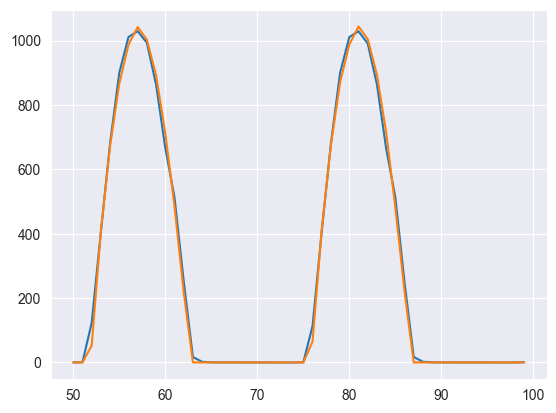

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])
plt.legend()

In [22]:

val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1.flatten()})
val_results.head(20)

274/274 [==============================] - 2s 7ms/step


,Val Predictions,Actuals
0,-0.135784,0.00
1,-0.151756,0.00
2,-0.163404,0.00
3,-0.161626,0.00
4,1.488578,0.00
5,158.845001,87.44
6,414.581238,429.21
7,683.185486,701.00
8,904.405273,896.93
9,1012.383972,1032.36


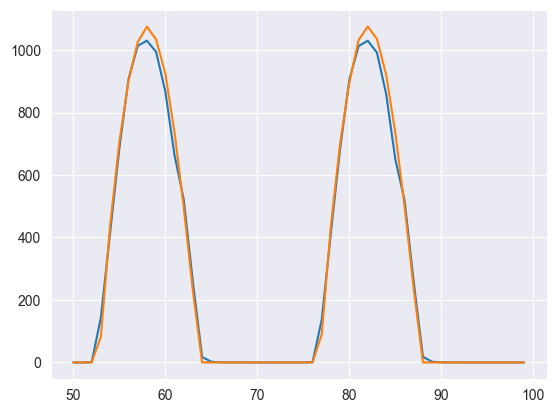

In [23]:
plt.plot(val_results['Val Predictions'][50:100])
plt.plot(val_results['Actuals'][50:100])

In [24]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results

822/822 [==============================] - 7s 9ms/step


,Test Predictions,Actuals
0,-0.154124,0.00
1,-0.165772,0.00
2,-0.162710,0.00
3,0.447278,0.00
4,86.866661,26.93
...,...,...
26274,0.026251,0.00
26275,-0.046144,0.00
26276,-0.085659,0.00
26277,-0.109087,0.00


In [26]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=50, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

822/822 [==============================] - 7s 9ms/step


(       Predictions  Actuals
 0        -0.154124     0.00
 1        -0.165772     0.00
 2        -0.162710     0.00
 3         0.447278     0.00
 4        86.866661    26.93
 ...            ...      ...
 26274     0.026251     0.00
 26275    -0.046144     0.00
 26276    -0.085659     0.00
 26277    -0.109087     0.00
 26278    -0.125076     0.00
 
 [26279 rows x 2 columns],
 6045.701122599702)

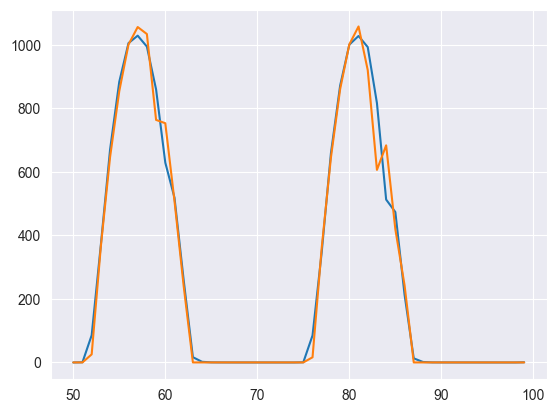

In [27]:
plot_predictions1(model1, X_test1, y_test1.flatten())

In [28]:
kkk = df_scaled[78866:78890,0]
print(type(kkk))
print(kkk.shape)
reshaped_array = np.reshape(kkk, (1, 24, 1))
print(reshaped_array)
predictions = model1.predict(reshaped_array)
print(predictions)
 
# original= scaler.inverse_transform(predictions)
# print(original)
# predictions
# inverse_data = np.zeros((len(predictions), scaler.shape[1]))

<class 'numpy.ndarray'>
(24,)
[[[   0.  ]
  [   0.  ]
  [  32.27]
  [ 390.79]
  [ 662.61]
  [ 859.19]
  [ 984.91]
  [1037.92]
  [1002.38]
  [ 894.79]
  [ 712.07]
  [ 467.98]
  [ 205.25]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]]]
1/1 [==============================] - 1s 1s/step
[[-0.16100913]]


In [29]:

input = df_scaled[78866:78890,0]  # Initial input extracted from your original scaled DataFrame
output_scaled = []  
output_not_scaled = [] 

for i in range(24):
    # Reshape input for the model prediction
    reshaped_array = np.reshape(input, (1, 24, 1))
    prediction = model1.predict(reshaped_array)
    
    # Reshape the prediction to match the input shape if necessary
    # Adjust the reshaping based on the actual shape of your model's output
    prediction_reshaped = np.reshape(prediction, (1, 1))
    input = np.reshape(input, (24, 1))  # Ensure input is in the correct shape before appending
    # Append the new prediction at the end of the input array
    input = np.vstack([input, prediction_reshaped])  # Stack vertically to add as a new row
    
    # Remove the oldest entry to maintain the sliding window of input data
    input = input[1:, :]  # Keep the last 24 entries, including the newly added prediction
 
    output_scaled.append(prediction)


# print(output_scaled)  # Remains empty, uncomment if needed
print(output_scaled)  # Print or process the predictions as 




1/1 [==============================] - 0s 32ms/step
[array([[-0.16100913]], dtype=float32), array([[0.4433058]], dtype=float32), array([[92.489944]], dtype=float32), array([[411.62964]], dtype=float32), array([[680.3129]], dtype=float32), array([[896.4519]], dtype=float32), array([[1008.8475]], dtype=float32), array([[1027.2234]], dtype=float32), array([[975.4147]], dtype=float32), array([[821.8523]], dtype=float32), array([[615.2143]], dtype=float32), array([[408.7634]], dtype=float32), array([[201.68513]], dtype=float32), array([[13.615229]], dtype=float32), array([[1.6572679]], dtype=float32), array([[0.21550119]], dtype=float32), array([[0.02838677]], dtype=float32), array([[-0.04295987]], dtype=float32), array([[-0.08206856]], dtype=float32), array([[-0.10528094]], dtype=float32), array([[-0.12101501]], dtype=float32), array([[-0.13438326]], dtype=float32), array([[-0.15149558]], dtype=float32), array([[-0.1646908]], dtype=float32)]


In [30]:
print("this is the real scaled output")
for i in output_scaled:
    print(i[0][0])

this is the real scaled output
-0.16100913
0.4433058
92.489944
411.62964
680.3129
896.4519
1008.8475
1027.2234
975.4147
821.8523
615.2143
408.7634
201.68513
13.615229
1.6572679
0.21550119
0.028386772
-0.04295987
-0.08206856
-0.105280936
-0.12101501
-0.13438326
-0.15149558
-0.1646908
